# Nonlinear Models (MACS 30100)
### by [Richard W. Evans](https://sites.google.com/site/rickecon/), February 2018
The code in this Jupyter notebook was written using Python 3.6. It uses data files [`Titanic dataset`](https://raw.githubusercontent.com/BigDataGal/Python-for-Data-Science/master/titanic-train.csv). For the code to run properly, you will either need to have access to the internet or you should have the data file in the same folder as the Jupyter notebook file. Otherwise, you will have to change the respective lines of the code that read in the data to reflect the location of that data.

This notebook follows some of the material in James, et al (2013, Ch. 7). We will cover:

1. Polynomial regression
2. Step functions
3. Splines

## 1. Polynomial regression
In both the [linear regression notebook](https://github.com/UC-MACSS/persp-model_W18/blob/master/Notebooks/LinRegress/LinRegress.ipynb) and in the [logistic regression notebook](https://github.com/UC-MACSS/persp-model_W18/blob/master/Notebooks/Classfcn1/KKNlogitLDA.ipynb), we discussed the method of including squared coefficients and cross products in order to capture nonlinearities and interactions, respectively, in a linear model. A standard univariate linear regression of feature $x_i$ on dependent variable $y_i$ is the following.

$$ y_i = \beta_0 + \beta_1 x_{i} + u_i $$

A polynomial function of degree $d$ is the following.

$$ y_i = \beta_0 + \beta_1 x_{i} + \beta_2 x_i^2 + \beta_3 x_i^3 + ... \beta_d x_i^d + u_i $$

The left panel of Figure 7.1 is James, et al (2013) shows a degree-4 polynomial of `wage` on `age`.

$$ wage_i = \beta_0 + \beta_1 age_i + \beta_2 age_i^2 + \beta_3 age_i^3 + \beta_4 age_i^4 + u_i $$

![Figure7_1.png](attachment:Figure7_1.png)

The solid blue line is the predicted value from this regression and the dotted lines are 95-percent confidence intervals on the predicted values.

The right panel of Figure 7.1 is a degree-4 polynomial in a logit model predicting the probability that $wage_i>\$250,000$.

**QUESTION**: Why are the confidence intervals so big for old-age predictions?

In [23]:
# Import needed stuff
import numpy as np
import pandas as pd
from pandas import Series, DataFrame
import statsmodels.api as sm

In [24]:
# Read in Wage data
wage_dta = pd.read_csv('Wage.txt', sep=',')
print(wage_dta.describe())
wage = wage_dta['wage']
age = wage_dta['age']
wage_dta['age2'] = wage_dta['age'] ** 2
wage_dta['age3'] = wage_dta['age'] ** 3
wage_dta['age4'] = wage_dta['age'] ** 4
wage_dta['const'] = 1

reg1 = sm.OLS(endog=wage_dta['wage'],
              exog=wage_dta[['const', 'age', 'age2', 'age3', 'age4']],
              missing='drop')
reg1_results = reg1.fit()
print(reg1_results.summary())

                  id         year          age      logwage         wage
count    3000.000000  3000.000000  3000.000000  3000.000000  3000.000000
mean   218883.373000  2005.791000    42.414667     4.653905   111.703608
std    145654.072587     2.026167    11.542406     0.351753    41.728595
min      7373.000000  2003.000000    18.000000     3.000000    20.085537
25%     85622.250000  2004.000000    33.750000     4.447158    85.383940
50%    228799.500000  2006.000000    42.000000     4.653213   104.921506
75%    374759.500000  2008.000000    51.000000     4.857332   128.680488
max    453870.000000  2009.000000    80.000000     5.763128   318.342430
                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     70.69
Date:                Tue, 1

## 2. Step Functions
The class of polynomial functions from the previous section impose global structure on the function of the data $X$, in that the equation applies equally to all values of $X$. Step functions impose multiple regions of local structure on the values of $X$. A step function divides the support of $X$ into bins with well defined boundaries and mutually exclusive assignment. That is, the step function cannot be a correspondence and must be a one-to-one mapping between $X$ and $y$. More formally, the step function is a set of $K$ constant functions defined over $K$ bins of the entire support of $X$.

$$ y_i = \begin{cases} \beta_1 \:\:\:\,\quad\text{if}\quad X_{min}\leq X_i < X_1 \\
                       \beta_2 \:\:\:\,\quad\text{if}\quad X_1\leq X_i < X_2 \\
                       \vdots \\
                       \beta_{K-1} \quad\text{if}\quad X_{K-2}\leq X_i < X_{K-1} \\
                       \beta_K \:\:\:\,\quad\text{if}\quad X_{K-1}\leq X_i \leq X_{max}
         \end{cases} $$

We could characterize each of the cases in the above equation as a dummy variable $C_k(X)$, such that:

$$ C_k(X) = I\left(X_{k-1}\leq X < X_{k}\right) $$

And an observation $X_i$ must be in exactly one of the categories. We can rewrite the step function as a linear regression of dummy variable explanatory variables and in which the coefficients are the constant functions. Also notice that this regression has no constant. This is because each observation will be in one of the categories.

$$ y_i = \beta_1 C_1(X_i) + \beta_2 C_2(X_i) + ... \beta_{K-1} C_{K-1} + \beta_{K} C_{K} + u_i $$

The parameters of this model are the coefficients $\beta_1, \beta_2, ... \beta_K$ as well as the and the bin cutoffs for the boundaries of each category bin $X_1, X_2, ... X_{K-1}$.

The left panel of Figure 7.2 from James, et al (2013) shows a step function estimation of $wage$ on $age$ with three bins whose cutoffs are $Age_1=33$ and $Age_2=65$.

![Figure7_2.png](attachment:Figure7_2.png)

In [49]:
wage = wage_dta['wage']
age = wage_dta['age']
age_bin1 = (wage_dta2['age'] < 33).astype(int)
age_bin2 = ((age >= 33) & (age < 65)).astype(int)
age_bin3 = (age >= 65).astype(int)
X_step = pd.DataFrame(dict(age_bin1=age_bin1, age_bin2=age_bin2,
                           age_bin3=age_bin3))
X_step.describe()

,age_bin1,age_bin2,age_bin3
count,3000.00000,3000.000000,3000.000000
mean,0.22100,0.755000,0.024000
std,0.41499,0.430159,0.153075
min,0.00000,0.000000,0.000000
25%,0.00000,1.000000,0.000000
50%,0.00000,1.000000,0.000000
75%,0.00000,1.000000,0.000000
max,1.00000,1.000000,1.000000


In [50]:
reg2 = sm.OLS(endog=wage, exog=X_step, missing='drop')
reg2_results = reg2.fit()
print(reg2_results.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     103.5
Date:                Wed, 14 Feb 2018   Prob (F-statistic):           3.49e-44
Time:                        00:14:34   Log-Likelihood:                -15350.
No. Observations:                3000   AIC:                         3.071e+04
Df Residuals:                    2997   BIC:                         3.072e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
age_bin1      92.3224      1.568     58.882      0.0

## 3. Splines
In Section 1, we discussed fitting global polynomials to the data, such that the polynomial function applied to all values of $X_i$. However, analogous to what we did with the stepwise functions, we can also fit a series of polynomials to the data over segments of the support of $X$ and make sure that the polynomials connect smoothly at the *knot points*.

The term "spline" has the meaning of something that goes between or bridges. In functional analysis, a spline is a discrete set of functions that span a domain. Taken together, these subfunctions create a super function, which we call a *spline*. The step function from the previous section is a spline in which each of the sub functions is a constant $\beta$. We will treat *linear splines* and *cubic splines* in this section. But really any *basis function* as the subfunctions that make up a spline.

We start with linear splines, then move to cubic splines. These can be used for fitting data. But another powerful use of splines is for *interpolation*, or the predicting of function values over intervals in which you have no data but which values are interior to the set of points for which you have data. *Extrapolation* is the predicting of function values over intervals for which you have no data by which values are exterior to the set of points for which you have data.

Figure 7.3 from James, et al (2013) shows some different types of splines

![Figure7_3.png](attachment:Figure7_3.png)

* A **piecewise spline** does not require that the function values match up at the endpoints or cutoff values of each bin.
* A **continuous piecewise spline** requires that the function values equal each other at the cutoff values of each bin, but it does not require that the first derivatives (the slopes) be the same at the cutoffs.
* A **continuous spline** or just **spline** requires both that the function values and the first derivatives be equal at the cutoff values of each bin.

### 3.1. Linear spline
A linear spline is shown in the lower-right panel of Figure 7.3 above. A linear spline is a series of $K$ linear functions that are fit of $K$ bins of the support of regressors, independent variables, or features $X$.

$$ y_i = f(X_i|\beta) = \begin{cases}
           \beta_{1,0} + \beta_{1,1}X_i \quad\text{if}\quad X_{min} \leq X_i < X_1 \\
           \beta_{2,0} + \beta_{2,1}X_i \quad\text{if}\quad X_1 \leq X_i < X_2 \\
           \vdots \\
           \beta_{K,0} + \beta_{K,1}X_i \quad\text{if}\quad X_{K-1} \leq X_i \leq X_{max} \\
         \end{cases} $$

If this is a continuous spline, and you are taking the cutoffs $\{X_1,X_2,...X_{K-1}\}$ as given, the estimation problem is the following.

$$ \min_{\{\beta_{k,0},\beta_{k,1}\}_{k=1}^K} \sum_{i=1}^N \left(y_i - f(X_i|\beta\right)^2 $$

$$ \text{s.t}\quad $$


### 3.2 Cubic spline
A cubic spline is a series of $K$ degree-3 polynomials that are fit over $K$ bins, connect at the end points and have a smooth first and

(3000,) (3000,)
count    3000.000000
mean       42.414667
std        11.542406
min        18.000000
25%        33.750000
50%        42.000000
75%        51.000000
max        80.000000
Name: age, dtype: float64


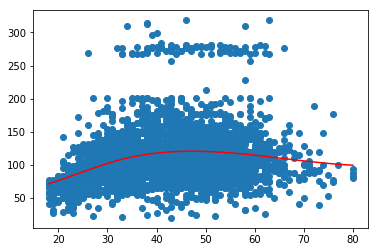

In [67]:
import scipy.interpolate as intpl
import matplotlib.pyplot as plt

print(wage.values.shape, age.values.shape)
print(age.describe())
knots = [33.0]
spl = intpl.LSQUnivariateSpline(age.values, wage.values, knots, k=3)

age_vec = np.linspace(age.values.min(), age.values.max(), 1000)
plt.scatter(age, wage)
plt.plot(age_vec, spl(age_vec), 'r-')
plt.show()

## References
* James, Gareth, Deaniela Witten, Trevor Hastie, and Robert Tibshirani, [*An Introduction to Statistical Learning with Applications in R*](http://link.springer.com.proxy.uchicago.edu/book/10.1007%2F978-1-4614-7138-7), New York, Springer (2013).